In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle, importlib
import argparse
import subprocess
import sys
import lime
import lime.lime_tabular
import shap
%matplotlib inline

In [32]:
# Generate kmeans summarization of training data 
# Example for transphla training data
# Caution: If you have 9 mer, make sure you summarize only 9-mer training peptide
# Note: In the repo we didn't provide training data of the predictors which can be downloaded from respective repos

AA = ['0=A','1=R','2=N','3=D','4=C','5=E','6=Q','7=G','8=H','9=I','10=L','11=K','12=M','13=F','14=P','15=S','16=T','17=W','18=Y','19=V','20=B','21=J','22=O','23=U','24=X','25=Z']
        
def AA_to_num(peptide):
    values = dict([(x.split('=')[1], x.split('=')[0]) for x in AA])
    peptide = np.array(list(map(lambda x: values[x], peptide)))
    return peptide

def num_to_AA(peptide):
    values = dict([(int(x.split('=')[0]), x.split('=')[1]) for x in AA])
    peptide = list(map(lambda x: values[x], peptide))
    str_peptide = ''
    for aa in peptide:
        str_peptide+=aa
    return str_peptide

def transform_train(train_file):
    train = np.array([AA_to_num(peptide) for peptide in train_file],dtype='<U20')
    return train.astype(float)

train_file = "../transPHLA/TransPHLA-AOMP/Dataset/train_set.csv" # Add path to your HLA seqs

train = pd.read_csv(train_file).drop_duplicates('HLA_sequence')
train = train['HLA_sequence'].to_list()
train = transform_train(train)
train_summary = shap.kmeans(train, 50)

# if you need to save training data in numpy
# np.save("./data/training_kmeans/transPHLA_HLA.npy",train)

filehandler = open('./data/training_kmeans/transPHLA_HLA.pkl', 'wb') 
pickle.dump(train_summary, filehandler)
filehandler.close()

LIME done
SHAP done


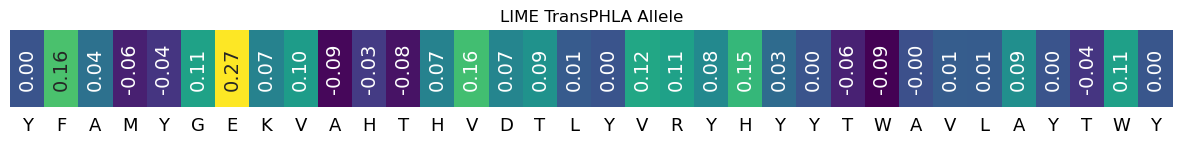

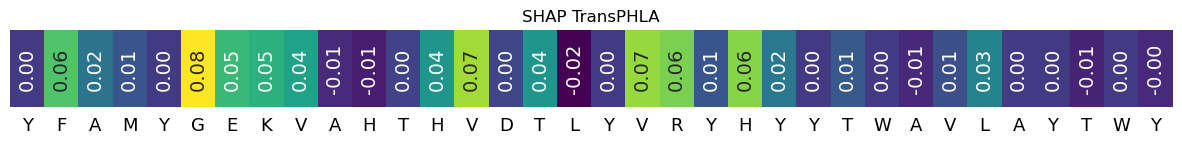

In [42]:
# LIME 
command = ["python", "./src/MHCXAI_allele.py",
           "--input_list", "./example/peptide_allele_transphla.csv",
           "--index", "0",
           "--predictor","transphla",
           "--xai","LIME",
           "--mode","None",
           "--trainf_path","./transPHLA/TransPHLA-AOMP/Dataset/train_set.csv",
           "--dest",'./example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("LIME done")

# SHAP 
command = ["python", "./src/MHCXAI_allele.py",
           "--input_list", "./example/peptide_allele_transphla.csv",
           "--index", "0",
           "--predictor","transphla",
           "--xai","SHAP",
           "--mode","None",
           "--trainf_path","/exports/csce/eddie/inf/groups/ajitha_project/piyush/tasks_notebooks/GitHub/data/training_kmeans/transPHLA_HLA.pkl",
           "--dest",'/exports/csce/eddie/inf/groups/ajitha_project/piyush/tasks_notebooks/GitHub/example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("SHAP done")

# Plot
#1
fig,ax = plt.subplots(1,1,figsize=(15,1))
peptide = 'YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY'
values = np.load('./example/LIME_LLVEVLREI_HLA-A*02:01_transphla_None_allele.npy')[1:-2]
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax)

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("LIME TransPHLA Allele")

#2
fig,ax = plt.subplots(1,1,figsize=(15,1))
values = np.load('./example/SHAP_LLVEVLREI_HLA-A*02:01_transphla_None_allele.npy')
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax)

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("SHAP TransPHLA")


plt.show()